## Intent Classification for the ATIS Dataset using BERT.
In this notebook we build a binarry classifier for the ATIS Dataset using [BERT](https://arxiv.org/abs/1810.04805), a pre-Trained NLP model open soucred by google in late 2018 that can be used for [Transfer Learning](https://towardsdatascience.com/transfer-learning-in-nlp-fecc59f546e4) on text data. This notebook has been adapted from this [Article](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03). The link for the dataset can be found [here](https://www.kaggle.com/siddhadev/ms-cntk-atis/data#).<br> This notebook requires a GPU to get setup. We suggest you to run this on your local machine only if you have a GPU setup or else you can use google colab.

## Imports

In [2]:
import warnings
warnings.filterwarnings("ignore")

# install
!pip install pytorch-pretrained-bert pytorch-nlp

try : 
    from google.colab import files
    %tensorflow_version 1.x
    
except ModuleNotFoundError :
    print("Not Using Colab")

DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf

# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

     |████████████████████████████████| 123 kB 6.4 MB/s 
     |████████████████████████████████| 90 kB 11.0 MB/s 
     |████████████████████████████████| 131 kB 53.0 MB/s 
     |████████████████████████████████| 7.8 MB 51.5 MB/s 
     |████████████████████████████████| 79 kB 10.1 MB/s 
     |████████████████████████████████| 138 kB 72.3 MB/s 
     |████████████████████████████████| 127 kB 73.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
TensorFlow 1.x selected.


Using TensorFlow backend.


## Data Loading

In [3]:
!wget https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch6/Data/data/atis.test.pkl
!wget https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch6/Data/data/atis.train.pkl

!wget https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch6/Data/data2/atis.train.w-intent.iob
!wget https://raw.githubusercontent.com/practical-nlp/practical-nlp-code/master/Ch6/Data/data2/atis-2.dev.w-intent.iob

--2021-08-03 01:09:11--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch6/Data/data/atis.test.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 277306 (271K) [application/octet-stream]
Saving to: ‘atis.test.pkl’

atis.test.pkl       100%[===================>] 270.81K  --.-KB/s    in 0.02s   

2021-08-03 01:09:11 (11.8 MB/s) - ‘atis.test.pkl’ saved [277306/277306]

--2021-08-03 01:09:11--  https://raw.githubusercontent.com/practical-nlp/practical-nlp/master/Ch6/Data/data/atis.train.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting

In [3]:
# # importing the dataset
# try :
#     from google.colab import files
# #   upload 'atis.test.pkl' and 'atis.train.pkl' here
#     uploaded = files.upload()
# #   upload 'atis.train.w-intent.iob' here
#     next_uploaded = files.upload() 
    
# except ModuleNotFoundError : 
#     print("Not using Colab")

In [4]:
#preprocessing functions
def get_data(filename):
    df = pd.read_csv(filename,delim_whitespace=True,names=['word','label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents,labels,intents = [],[],[]
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    return np.array(sents),np.array(labels),np.array(intents)

def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents,labels,intents = [],[],[]
    for line in contents.strip().split('\n'):
        words,labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    return np.array(sents),np.array(labels),np.array(intents)

In [35]:
# '''test get_data function'''
# d = {'word': ['BOS', 'i', 'want', 'to', 'fly', 'to', 'Boston', 'EOS', 'BOS', 'i', 'want', 'to', 'fly', 'to', 'Baltimore', 'EOS'], 
# 'label': ['O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'atis_flight',  'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'atis_flight']}
# df = pd.DataFrame(data=d)
# beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
# sents,labels,intents = [],[],[]
# for i in range(len(beg_indices[:-1])):
#     sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
#     labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
#     intents.append(df.loc[beg_indices[i+1]-1]['label']) 

# # print(sents)
# # print(labels)
# # print(intents)

# print(np.array(sents))
# print(np.array(labels))
# print(np.array(intents))

# i = 1
# print(beg_indices)
# print(beg_indices[i]+1,beg_indices[i+1]-1)
# print(beg_indices[i+1]-1)

[['i' 'want' 'to' 'fly' 'to' 'Boston']
 ['i' 'want' 'to' 'fly' 'to' 'Baltimore']]
[['O' 'O' 'O' 'O' 'O' 'B-fromloc.city_name']
 ['O' 'O' 'O' 'O' 'O' 'B-fromloc.city_name']]
['atis_flight' 'atis_flight']
[0, 8, 16]
9 15
15


In [5]:
print("Loading the training Data")
try : 
    from google.colab import files
    sents,labels,intents = get_data2('atis.train.w-intent.iob')
    
except ModuleNotFoundError :
    sents,labels,intents = get_data2('Data/data2/atis.train.w-intent.iob')

train_sentences = [" ".join(i) for i in sents]

train_texts = train_sentences
train_labels= intents.tolist()

vals = []

for i in range(len(train_labels)):
    if "#" in train_labels[i]:
        vals.append(i)
        
for i in vals[::-1]:
    train_labels.pop(i)
    train_texts.pop(i)

print ("Number of training sentences :",len(train_texts))
print ("Number of unique intents :",len(set(train_labels)))

for i in zip(train_texts[:5], train_labels[:5]):
    print(i)

Loading the training Data
Number of training sentences : 4952
Number of unique intents : 17
('i want to fly from boston at 838 am and arrive in denver at 1110 in the morning', 'atis_flight')
('what flights are available from pittsburgh to baltimore on thursday morning', 'atis_flight')
('what is the arrival time in san francisco for the 755 am flight leaving washington', 'atis_flight_time')
('cheapest airfare from tacoma to orlando', 'atis_airfare')
('round trip fares from pittsburgh to philadelphia under 1000 dollars', 'atis_airfare')


In [6]:
# load Pickle file 
def load_ds(fname, verbose=True):
    with open(fname, 'rb') as stream:
        ds,dicts = pickle.load(stream)
    if verbose:
        print('Done  loading: ', fname)
        print('      samples: {:4d}'.format(len(ds['query'])))
        print('   vocab_size: {:4d}'.format(len(dicts['token_ids'])))
        print('   slot count: {:4d}'.format(len(dicts['slot_ids'])))
        print(' intent count: {:4d}'.format(len(dicts['intent_ids'])))
    return ds,dicts
  
# convert Pickle file to arrays
def load_atis(filename, add_start_end_token=False, verbose=True):
    train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
    t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
    i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
    query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

    if add_start_end_token:
        i2s[178] = 'BOS'
        i2s[179] = 'EOS'
        s2i['BOS'] = 178
        s2i['EOS'] = 179

    input_tensor = []
    target_tensor = []
    query_data = []
    intent_data = []
    slot_data = []
    to_show = np.random.randint(0, len(query)-1, 5)
    for i in range(len(query)):
        input_tensor.append(query[i])
        slot_text = []
        slot_vector = []
        for j in range(len(query[i])):
            slot_text.append(i2s[slots[i][j]])
            slot_vector.append(slots[i][j])
        if add_start_end_token:
            slot_text[0] = 'BOS'
            slot_vector[0] = 178
            slot_text[-1] = 'EOS'
            slot_vector[-1]= 179
        target_tensor.append(slot_vector)
        q = ' '.join(map(i2t.get, query[i]))
        query_data.append(q.replace('BOS', '').replace('EOS',''))
        intent_data.append(i2in[intent[i][0]])
        slot = ' '.join(slot_text)
        slot_data.append(slot[1:-1])
        if i in to_show and verbose:
            print('Query text:', q)
            print('Query vector: ', query[i])
            print('Intent label: ', i2in[intent[i][0]])
            print('Slot text: ', slot)
            print('Slot vector: ', slot_vector)
            print('*'*74)
   
    query_data = np.array(query_data)
    intent_data = np.array(intent_data)
    slot_data = np.array(slot_data)
    intent_data_label = np.array(intent).flatten()
    
    return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data


In [28]:
# '''print out dicts and train_ds example'''
# # print('train_ds',train_ds.keys())
# # print('dicts',dicts.keys())
# # print(train_ds['slot_labels'][0])
# # print(dicts['token_ids'])

# i, j = 0,6
# print(query[i])
# print(slots[i])
# print(i2s[slots[i][j]])
# print(i2t.get(query[i][j]))
# print(intent[0])

[178 479 902 851 431 444 266 240 168 210 215 236 482 351 240  27 482 827
 606 179]
[128 128 128 128 128 128  48 128  35 100 128 128 128  78 128  14 128 128
  12 128]
B-fromloc.city_name
boston
[14]


In [9]:
# '''test load_atis '''
# filename,fname = 'atis.train.pkl', 'atis.train.pkl'
# add_start_end_token=False
# verbose=True

# train_ds, dicts = load_ds(os.path.join(DATA_DIR,filename), verbose)
# t2i, s2i, in2i = map(dicts.get, ['token_ids', 'slot_ids','intent_ids'])
# i2t, i2s, i2in = map(lambda d: {d[k]:k for k in d.keys()}, [t2i,s2i,in2i])
# query, slots, intent =  map(train_ds.get, ['query', 'slot_labels', 'intent_labels'])

# if add_start_end_token:
#     i2s[178] = 'BOS'
#     i2s[179] = 'EOS'
#     s2i['BOS'] = 178
#     s2i['EOS'] = 179

# input_tensor = []
# target_tensor = []
# query_data = []
# intent_data = []
# slot_data = []
# to_show = np.random.randint(0, len(query)-1, 5)
# for i in range(len(query)):
#     input_tensor.append(query[i])
#     slot_text = []
#     slot_vector = []
#     for j in range(len(query[i])):
#         slot_text.append(i2s[slots[i][j]])
#         slot_vector.append(slots[i][j])
#     if add_start_end_token:
#         slot_text[0] = 'BOS'
#         slot_vector[0] = 178
#         slot_text[-1] = 'EOS'
#         slot_vector[-1]= 179
#     target_tensor.append(slot_vector)
#     q = ' '.join(map(i2t.get, query[i]))
#     query_data.append(q.replace('BOS', '').replace('EOS',''))
#     intent_data.append(i2in[intent[i][0]])
#     slot = ' '.join(slot_text)
#     slot_data.append(slot[1:-1])
#     if i in to_show and verbose:
#         print('Query text:', q)
#         print('Query vector: ', query[i])
#         print('Intent label: ', i2in[intent[i][0]])
#         print('Slot text: ', slot)
#         print('Slot vector: ', slot_vector)
#         print('*'*74)

# query_data = np.array(query_data)
# intent_data = np.array(intent_data)
# slot_data = np.array(slot_data)
# intent_data_label = np.array(intent).flatten()
# # return t2i, s2i, in2i, i2t, i2s, i2in, input_tensor, target_tensor, query_data, intent_data, intent_data_label, slot_data

Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS show flights from denver to oakland arriving between 12 and 1 o'clock EOS
Query vector:  [178 770 429 444 351 851 644 238 259  33 215   9 642 179]
Intent label:  flight
Slot text:  O O O O B-fromloc.city_name O B-toloc.city_name O O B-arrive_time.start_time O B-arrive_time.end_time I-arrive_time.end_time O
Slot vector:  [128, 128, 128, 128, 48, 128, 78, 128, 128, 13, 128, 10, 86, 128]
**************************************************************************
Query text: BOS show me the flights from love field EOS
Query vector:  [178 770 581 827 429 444 565 418 179]
Intent label:  flight
Slot text:  O O O O O O B-fromloc.airport_name I-fromloc.airport_name O
Slot vector:  [128, 128, 128, 128, 128, 128, 47, 109, 128]
**************************************************************************
Query text: BOS phoenix to denver EOS
Query vector:  [178 681 851 351 1

In [36]:
# load ATIS training dataset
try : 
    from google.colab import files
    t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
    input_tensor_train, target_tensor_train, \
    query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('atis.train.pkl')
    
except ModuleNotFoundError :
    t2i_train, s2i_train, in2i_train, i2t_train, i2s_train, i2in_train, \
    input_tensor_train, target_tensor_train, \
    query_data_train, intent_data_train, intent_data_label_train, slot_data_train = load_atis('Data/data/atis.train.pkl')

# load ATIS testing dataset
try : 
    from google.colab import files
    t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
    input_tensor_test, target_tensor_test, \
    query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('atis.test.pkl')
    
except ModuleNotFoundError :
    t2i_test, s2i_test, in2i_test, i2t_test, i2s_test, i2in_test, \
    input_tensor_test, target_tensor_test, \
    query_data_test, intent_data_test, intent_data_label_test, slot_data_test = load_atis('Data/data/atis.test.pkl')


Done  loading:  ./atis.train.pkl
      samples: 4978
   vocab_size:  943
   slot count:  129
 intent count:   26
Query text: BOS what is the latest flight between washington and boston EOS
Query vector:  [178 916 498 827 532 428 259 905 215 266 179]
Intent label:  flight
Slot text:  O O O O B-flight_mod O O B-fromloc.city_name O B-toloc.city_name O
Slot vector:  [128, 128, 128, 128, 42, 128, 128, 48, 128, 78, 128]
**************************************************************************
Query text: BOS can i see ground transportation from long beach airport to downtown EOS
Query vector:  [178 282 479 754 457 866 444 559 252 203 851 380 179]
Intent label:  ground_service
Slot text:  O O O O O O O B-fromloc.city_name I-fromloc.city_name O O O O
Slot vector:  [128, 128, 128, 128, 128, 128, 128, 48, 110, 128, 128, 128, 128]
**************************************************************************
Query text: BOS list the flights from denver to baltimore EOS
Query vector:  [178 549 827 42

Let's look at a few training queries.

In [37]:
query_data_train

array([' i want to fly from boston at 838 am and arrive in denver at 1110 in the morning ',
       ' what flights are available from pittsburgh to baltimore on thursday morning ',
       ' what is the arrival time in san francisco for the 755 am flight leaving washington ',
       ..., ' which airlines fly into and out of denver ',
       ' does continental fly from boston to san francisco with a stop in denver ',
       ' is there a delta flight from denver to san francisco '],
      dtype='<U261')

## Data Pre-processing
We need to convert the sentences to tensors.

In [40]:
#function to find the length of a tensor
def max_length(tensor):
    return max(len(t) for t in tensor)

# Helper function to pad the query tensor and slot (target) tensor to the same length. 
# Also creates a tensor for teacher forcing.
def create_tensors(input_tensor, target_tensor, nb_sample=9999999, max_len=0):
    len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
    len_input = max(len_input,max_len)
    len_target = max(len_target,max_len)
    

    # Padding the input and output tensor to the maximum length
    input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=len_input,
                                                                 padding='post')

    teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=len_target , 
                                                                  padding='post')
    
    target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
    target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
    target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))
    
    nb = len(input_data)
    p = np.random.permutation(nb)
    input_data = input_data[p]
    teacher_data = teacher_data[p]
    target_data = target_data[p]

    return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 
           
input_data_train, teacher_data_train, target_data_train, \
                  len_input_train, len_target_train  = create_tensors(input_tensor_train, target_tensor_train)
input_data_test, teacher_data_test, target_data_test, \
                 len_input_test, len_target_test  = create_tensors(input_tensor_test, target_tensor_test, max_len=len_input_train)


BERT expects data to be in a specific format, i.e, [CLS] token1,token2,....[SEP]

In [41]:
# '''test create_tensors'''
# input_tensor, target_tensor = input_tensor_train, target_tensor_train
# nb_sample=9999999
# max_len=0

# len_input, len_target  = max_length(input_tensor), max_length(target_tensor)
# len_input = max(len_input,max_len)
# len_target = max(len_target,max_len)


# # Padding the input and output tensor to the maximum length
# input_data = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
#                                                               maxlen=len_input,
#                                                               padding='post')

# teacher_data = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
#                                                               maxlen=len_target , 
#                                                               padding='post')

# target_data = [[teacher_data[n][i+1] for i in range(len(teacher_data[n])-1)] for n in range(len(teacher_data))]
# target_data = tf.keras.preprocessing.sequence.pad_sequences(target_data, maxlen=len_target, padding="post")
# target_data = target_data.reshape((target_data.shape[0], target_data.shape[1], 1))

# nb = len(input_data)
# p = np.random.permutation(nb)
# input_data = input_data[p]
# teacher_data = teacher_data[p]
# target_data = target_data[p]

# # return input_data[:min(nb_sample, nb)], teacher_data[:min(nb_sample, nb)], target_data[:min(nb_sample, nb)], len_input, len_target 

In [77]:
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

[CLS]  i want to fly from boston at 838 am and arrive in denver at 1110 in the morning  [SEP]


100%|██████████| 231508/231508 [00:00<00:00, 937529.20B/s]


Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


In [86]:
# Set the maximum sequence length. 
MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Creating the BERT attention masks

In [14]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  

In [15]:
#Reducing this into a binary classifcation problem, 14 is for flight
intent_data_label_train[intent_data_label_train==14] = -1
intent_data_label_train[intent_data_label_train!=-1] = 0
intent_data_label_train[intent_data_label_train==-1] = 1

In [16]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, intent_data_label_train, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Training

In [17]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

if torch.cuda.is_available():
    model.cuda()
else :
    model

100%|██████████| 407873900/407873900 [00:10<00:00, 37686625.50B/s]


## Fine-Tuning BERT

t_total value of -1 results in schedule not being applied
Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.1099538401650664


Epoch:  25%|██▌       | 1/4 [01:57<05:51, 117.27s/it]

Validation Accuracy: 0.9921875
Train loss: 0.032703832633394214


Epoch:  50%|█████     | 2/4 [03:59<03:57, 118.85s/it]

Validation Accuracy: 0.990234375
Train loss: 0.014419710373788672


Epoch:  75%|███████▌  | 3/4 [06:03<02:00, 120.38s/it]

Validation Accuracy: 0.994140625
Train loss: 0.006200505690399691


Epoch: 100%|██████████| 4/4 [08:07<00:00, 121.97s/it]

Validation Accuracy: 0.99609375


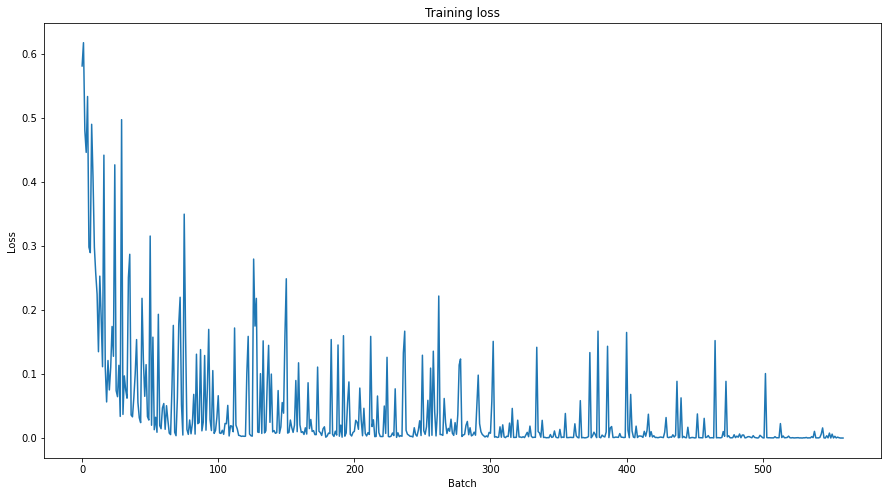

In [18]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

    # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()